In [350]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, MiniBatchKMeans
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [351]:
def load_images(root_path, file_names, normalize=True):
    """
    Retorna una lista con arreglos de números. Cada arreglo representa una imagen RGB.
    
    Parametros:
    root_path : str
        Directorio raíz de las imágenes.
    file_names : list
        Lista con los nombres de los archivos de imágenes.
    flatten : bool, opcional
        Si es True, aplana las imágenes a una lista de píxeles de tres dimensiones.
    normalize : bool, opcional
        Si es True, normaliza los valores de píxeles al rango [0, 1].
    """
    image_list = list()
    for file in file_names:
        img = cv2.imread(os.path.join(root_path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if normalize:
            img = img / 255.0
        image_list.append(img)
    return image_list

In [352]:
root_path = 'images'

In [353]:
img_files = os.listdir(root_path)
img_files

['img2.jpg', 'img5.jpg', 'img1.jpg', 'img3.jpg', 'img4.jpg']

In [354]:
# Cargar imágenes
img_list = load_images(root_path, img_files, normalize=True)


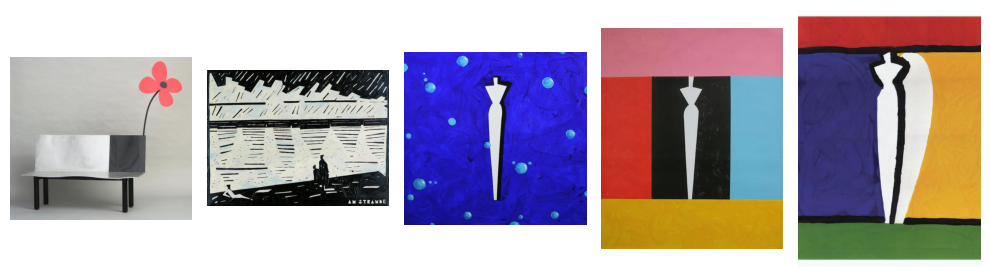

In [355]:
plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(img_list[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [356]:
image_number = input('Ingrese el número de la imagen que desea analizar: ')
image_number = int(image_number)
image_number

1

In [357]:
# Resize image
def resize_img(image, size=(150, 150)):
    """
    Redimensiona una imagen a un tamaño específico.
    
    Parametros:
    image : numpy.ndarray
        Arreglo de números que representa una imagen RGB.
    size : tuple, opcional
        Tamaño al que se redimensionará la imagen.
    """
    return cv2.resize(image, size)

class Resizer(BaseEstimator, TransformerMixin):
    def __init__(self, proportion=0.5):
        self.proportion = proportion
    
    def fit(self, X, y=None):
        print(f"fit size: {X.shape}")
        self.size = (int(X.shape[0] * self.proportion), int(X.shape[1] * self.proportion))
        return self
    
    def transform(self, X):
        print(f"transform size: {self.size}")
        return resize_img(X, size=self.size)

In [358]:
def flatter_func(image):
    """
    Aplana una imagen a una lista de píxeles de tres dimensiones.
    
    Parametros:
    image : numpy.ndarray
        Arreglo de números que representa una imagen RGB.
    """
    return image.reshape((-1, 3))

class Flatter(BaseEstimator, TransformerMixin):
    """
    Aplana una imagen a una lista de píxeles de tres dimensiones.
    
    Parametros:
    image : numpy.ndarray
        Arreglo de números que representa una imagen RGB.
    """
    def __init__(self):
        pass

    def transform(self, X, **transform_params):
        return X.reshape((-1, 3))

    def fit(self, X, y=None, **fit_params):
        return self

In [359]:
# img_resized_flatten = Flatter().transform(img_resized)
# print(img_resized_flatten.shape)
# flat_transform = FunctionTransformer(flatter_func)
# pipe = Pipeline([("flat transform", Flatter())])
# pipe = Pipeline(["flat transform", flat_transform])
# pipe.fit_transform(img_resized).shape

In [360]:
pipe = Pipeline([("resizer", Resizer()), ("flat_transform", Flatter()), ("model", KMeans())])
pipe.set_params(model__n_clusters=5)
pipe.set_params(resizer__proportion=0.5)
result = pipe.fit(img_list[image_number])
labels = result.named_steps["model"].labels_
centroids = result.named_steps["model"].cluster_centers_
img_resized = result.named_steps["resizer"].transform(img_list[image_number])
print(img_resized.shape)
print(img_list[image_number].shape)

fit size: (1382, 1849, 3)
transform size: (691, 924)


/home/jordineil/Documents/maia/mlns/paleta_de_colores/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


transform size: (691, 924)
(924, 691, 3)
(1382, 1849, 3)


In [361]:
centroids_scaled = centroids*255

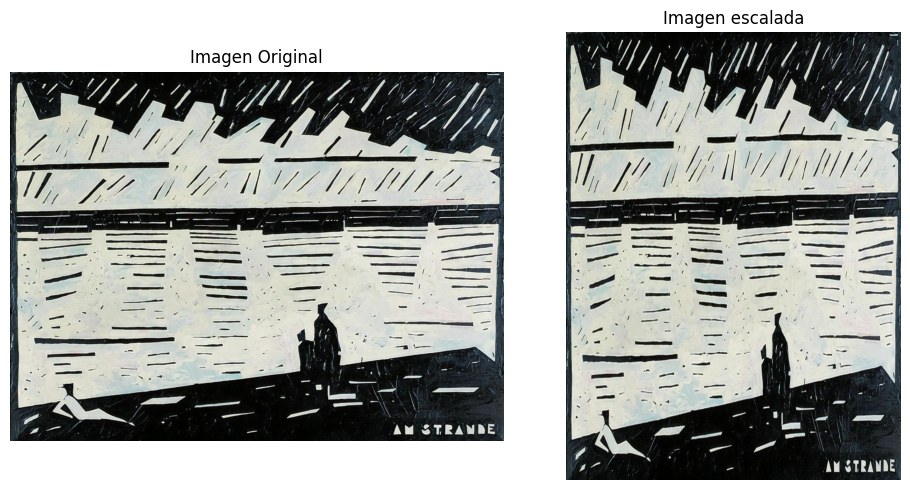

In [362]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(img_list[image_number])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen escalada')
plt.imshow(img_resized)
plt.axis('off')

plt.tight_layout()
plt.show()

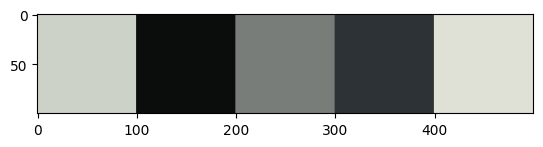

In [363]:
whiteblankimage = 255 * np.ones(shape=[100, 100*len(centroids_scaled), 3], dtype=np.uint8)

for i, color in enumerate(centroids_scaled):
    cv2.rectangle(whiteblankimage, pt1=(i*100,0), pt2=((i+1)*100,200), color=color, thickness=-1)

plt.imshow(whiteblankimage)

plt.show()